In [ ]:
import torch
from tqdm import tqdm
import numpy as np



class Diffusion:
    def __init__(self, noise_steps=4000, beta_start=1e-4, beta_end=0.02, img_size=256, device="cuda"):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.img_size = img_size
        self.device = device

        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1. - self.beta
        self.alpha_bar = torch.cumprod(self.alpha,axis=0)

        self.forward_mean = torch.sqrt(self.alpha_bar)
        self.forward_std = torch.sqrt((1-self.alpha_bar))

        self.reverse_factor = 1/torch.sqrt(self.alpha)
        self.reverse_term = self.beta/self.forward_std
        self.reverse_std = torch.sqrt(self.beta)

    def prepare_noise_schedule(self):
        timesteps = np.linspace(0, self.noise_steps, self.noise_steps, endpoint=False)
        s = 0.008
        cosine_schedule = 0.5 * (1 + np.cos(np.pi * (timesteps / self.noise_steps + s) / (1 + s)))
        betas = self.beta_start + (self.beta_end - self.beta_start) * cosine_schedule
        return torch.tensor(betas, dtype=torch.float32)

    def noise_images(self, x, t):
        noise = torch.randn_like(x)
        mean = self.extract(self.forward_mean, t, x.shape) * x
        std = self.extract(self.forward_std, t, noise.shape) * noise
        return mean + std, noise

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.noise_steps, size=(n,))

    def sample(self, model, n,grey):

        model.eval()
        with torch.no_grad():
            color = torch.randn((n, 3, self.img_size, self.img_size)).to(self.device)
            xt = torch.cat((grey, color), axis=1)
            for i in tqdm(reversed(range(1, self.noise_steps)), position=0):
                t = (torch.ones(n) * i).long().to(self.device)

                if i > 1:
                    z = torch.randn_like(color)
                else:
                    z = torch.zeros_like(color)

                pred_noise = model(xt, t)
                print(t, torch.min(pred_noise), torch.max(pred_noise))

                mean = self.extract(self.reverse_factor, t, color.shape) * (color - self.extract(self.reverse_term,t,pred_noise.shape)* pred_noise)
                std = self.extract(self.reverse_std, t, z.shape) * z

                color = mean + std
                xt = torch.cat((grey, color), axis=1)

        model.train()
        return color
    def extract(self,a, t, x_shape):
        b, *_ = t.shape
        out = a.gather(-1, t)
        return out.reshape(b, *((1,) * (len(x_shape) - 1)))
#         x = xt
#         x = (x.clamp(-1, 1) + 1) / 2
#         x = (x * 255).type(torch.uint8)
#         return color


In [ ]:
import os
from abc import abstractmethod
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

class GroupNorm32(nn.GroupNorm):
    def forward(self, x):
        return super().forward(x.float()).type(x.dtype)

def normalization(channels):
    """
    Make a standard normalization layer.
    :param channels: number of input channels.
    :return: an nn.Module for normalization.
    """
    return GroupNorm32(32, channels)

def zero_module(module):
    """
    Zero out the parameters of a module and return it.
    """
    for p in module.parameters():
        p.detach().zero_()
    return module

def checkpoint(func, inputs, params, flag):
    """
    Evaluate a function without caching intermediate activations, allowing for
    reduced memory at the expense of extra compute in the backward pass.
    :param func: the function to evaluate.
    :param inputs: the argument sequence to pass to `func`.
    :param params: a sequence of parameters `func` depends on but does not
                   explicitly take as arguments.
    :param flag: if False, disable gradient checkpointing.
    """
    if flag:
        args = tuple(inputs) + tuple(params)
        return CheckpointFunction.apply(func, len(inputs), *args)
    else:
        return func(*inputs)

def timestep_embedding(timesteps, dim, max_period=10000):
    """
    Create sinusoidal timestep embeddings.
    :param timesteps: a 1-D Tensor of N indices, one per batch element.
                      These may be fractional.
    :param dim: the dimension of the output.
    :param max_period: controls the minimum frequency of the embeddings.
    :return: an [N x dim] Tensor of positional embeddings.
    """
    half = dim // 2
    freqs = torch.exp(
        -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
    ).to(device=timesteps.device)
    args = timesteps[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2:
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    return embedding


class CheckpointFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, run_function, length, *args):
        ctx.run_function = run_function
        ctx.input_tensors = list(args[:length])
        ctx.input_params = list(args[length:])
        with torch.no_grad():
            output_tensors = ctx.run_function(*ctx.input_tensors)
        return output_tensors

    @staticmethod
    def backward(ctx, *output_grads):
        ctx.input_tensors = [x.detach().requires_grad_(True) for x in ctx.input_tensors]
        with torch.enable_grad():
            # Fixes a bug where the first op in run_function modifies the
            # Tensor storage in place, which is not allowed for detach()'d
            # Tensors.
            shallow_copies = [x.view_as(x) for x in ctx.input_tensors]
            output_tensors = ctx.run_function(*shallow_copies)
        input_grads = torch.autograd.grad(
            output_tensors,
            ctx.input_tensors + ctx.input_params,
            output_grads,
            allow_unused=True,
        )
        del ctx.input_tensors
        del ctx.input_params
        del output_tensors
        return (None, None) + input_grads

class EMA():
    def __init__(self, beta):
        super().__init__()
        self.beta = beta

    def update_model_average(self, ma_model, current_model):
        for current_params, ma_params in zip(current_model.parameters(), ma_model.parameters()):
            old_weight, up_weight = ma_params.data, current_params.data
            ma_params.data = self.update_average(old_weight, up_weight)

    def update_average(self, old, new):
        if old is None:
            return new
        return old * self.beta + (1 - self.beta) * new

class TimestepBlock(nn.Module):
    """
    Any module where forward() takes timestep embeddings as a second argument.
    """

    @abstractmethod
    def forward(self, x, emb):
        """
        Apply the module to `x` given `emb` timestep embeddings.
        """


class TimestepEmbedSequential(nn.Sequential, TimestepBlock):
    """
    A sequential module that passes timestep embeddings to the children that
    support it as an extra input.
    """

    def forward(self, x, emb):
        for layer in self:
            if isinstance(layer, TimestepBlock):
                x = layer(x, emb)
            else:
                x = layer(x)
        return x

class Upsample(nn.Module):
    """
    An upsampling layer with an optional convolution.
    :param channels: channels in the inputs and outputs.
    :param use_conv: a bool determining if a convolution is applied.

    """

    def __init__(self, channels, use_conv, out_channels=None):
        super().__init__()
        self.channels = channels
        self.out_channels = out_channels or channels
        self.use_conv = use_conv
        if use_conv:
            self.conv = nn.Conv2d(self.channels, self.out_channels, 3, padding=1)

    def forward(self, x):
        assert x.shape[1] == self.channels
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        if self.use_conv:
            x = self.conv(x)
        return x

class Downsample(nn.Module):
    """
    A downsampling layer with an optional convolution.
    :param channels: channels in the inputs and outputs.
    :param use_conv: a bool determining if a convolution is applied.
    """

    def __init__(self, channels, use_conv, out_channels=None):
        super().__init__()
        self.channels = channels
        self.out_channels = out_channels or channels
        self.use_conv = use_conv
        stride = 2
        if use_conv:
            self.op = nn.Conv2d(
                self.channels, self.out_channels, 3, stride=stride, padding=1
            )
        else:
            assert self.channels == self.out_channels
            self.op = nn.AvgPool2d(kernel_size=stride, stride=stride)

    def forward(self, x):
        assert x.shape[1] == self.channels
        return self.op(x)


class ResBlock(TimestepBlock):
    """
    A residual block that can optionally change the number of channels.
    :param channels: the number of input channels.
    :param emb_channels: the number of timestep embedding channels.
    :param dropout: the rate of dropout.
    :param out_channels: if specified, the number of out channels.
    :param use_conv: if True and out_channels is specified, use a spatial
        convolution instead of a smaller 1x1 convolution to change the
        channels in the skip connection.
    :param use_checkpoint: if True, use gradient checkpointing on this module.
    :param up: if True, use this block for upsampling.
    :param down: if True, use this block for downsampling.
    """

    def __init__(
        self,
        channels,
        emb_channels,
        dropout,
        out_channels=None,
        use_conv=False,
        use_scale_shift_norm=False,
        use_checkpoint=False,
        up=False,
        down=False,
    ):
        super().__init__()
        self.channels = channels
        self.emb_channels = emb_channels
        self.dropout = dropout
        self.out_channels = out_channels or channels
        self.use_conv = use_conv
        self.use_checkpoint = use_checkpoint
        self.use_scale_shift_norm = use_scale_shift_norm

        self.in_layers = nn.Sequential(
            normalization(channels),
            nn.SiLU(),
            nn.Conv2d(channels, self.out_channels, 3, padding=1),
        )

        self.updown = up or down

        if up:
            self.h_upd = Upsample(channels, False)
            self.x_upd = Upsample(channels, False)
        elif down:
            self.h_upd = Downsample(channels, False)
            self.x_upd = Downsample(channels, False)
        else:
            self.h_upd = self.x_upd = nn.Identity()

        self.emb_layers = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_channels,
                2 * self.out_channels if use_scale_shift_norm else self.out_channels,
            ),
        )
        self.out_layers = nn.Sequential(
            normalization(self.out_channels),
            nn.SiLU(),
            nn.Dropout(p=dropout),
            zero_module(
                nn.Conv2d(self.out_channels, self.out_channels, 3, padding=1)
            ),
        )

        if self.out_channels == channels:
            self.skip_connection = nn.Identity()
        elif use_conv:
            self.skip_connection = nn.Conv2d(
                channels, self.out_channels, 3, padding=1
            )
        else:
            self.skip_connection = nn.Conv2d(channels, self.out_channels, 1)

    def forward(self, x, emb):
        """
        Apply the block to a Tensor, conditioned on a timestep embedding.
        :param x: an [N x C x ...] Tensor of features.
        :param emb: an [N x emb_channels] Tensor of timestep embeddings.
        :return: an [N x C x ...] Tensor of outputs.
        """
        return checkpoint(
            self._forward, (x, emb), self.parameters(), self.use_checkpoint
        )

    def _forward(self, x, emb):
        if self.updown:
            in_rest, in_conv = self.in_layers[:-1], self.in_layers[-1]
            h = in_rest(x)
            h = self.h_upd(h)
            x = self.x_upd(x)
            h = in_conv(h)
        else:
            h = self.in_layers(x)
        emb_out = self.emb_layers(emb).type(h.dtype)
        while len(emb_out.shape) < len(h.shape):
            emb_out = emb_out[..., None]
        if self.use_scale_shift_norm:
            out_norm, out_rest = self.out_layers[0], self.out_layers[1:]
            scale, shift = torch.chunk(emb_out, 2, dim=1)
            h = out_norm(h) * (1 + scale) + shift
            h = out_rest(h)
        else:
            h = h + emb_out
            h = self.out_layers(h)
        return self.skip_connection(x) + h

class AttentionBlock(nn.Module):
    """
    An attention block that allows spatial positions to attend to each other.
    Originally ported from here, but adapted to the N-d case.
    https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/models/unet.py#L66.
    """

    def __init__(
        self,
        channels,
        num_heads=1,
        num_head_channels=-1,
        use_checkpoint=False,
        use_new_attention_order=False,
    ):
        super().__init__()
        self.channels = channels
        if num_head_channels == -1:
            self.num_heads = num_heads
        else:
            assert (
                channels % num_head_channels == 0
            ), f"q,k,v channels {channels} is not divisible by num_head_channels {num_head_channels}"
            self.num_heads = channels // num_head_channels
        self.use_checkpoint = use_checkpoint
        self.norm = normalization(channels)
        self.qkv = nn.Conv1d(channels, channels * 3, 1)
        if use_new_attention_order:
            # split qkv before split heads
            self.attention = QKVAttention(self.num_heads)
        else:
            # split heads before split qkv
            self.attention = QKVAttentionLegacy(self.num_heads)

        self.proj_out = zero_module(nn.Conv1d(channels, channels, 1))

    def forward(self, x):
        return checkpoint(self._forward, (x,), self.parameters(), True)

    def _forward(self, x):
        b, c, *spatial = x.shape
        x = x.reshape(b, c, -1)
        qkv = self.qkv(self.norm(x))
        h = self.attention(qkv)
        h = self.proj_out(h)
        return (x + h).reshape(b, c, *spatial)

def count_flops_attn(model, _x, y):
    """
    A counter for the `thop` package to count the operations in an
    attention operation.
    Meant to be used like:
        macs, params = thop.profile(
            model,
            inputs=(inputs, timestamps),
            custom_ops={QKVAttention: QKVAttention.count_flops},
        )
    """
    b, c, *spatial = y[0].shape
    num_spatial = int(np.prod(spatial))
    # We perform two matmuls with the same number of ops.
    # The first computes the weight matrix, the second computes
    # the combination of the value vectors.
    matmul_ops = 2 * b * (num_spatial ** 2) * c
    model.total_ops += torch.DoubleTensor([matmul_ops])

class QKVAttentionLegacy(nn.Module):
    """
    A module which performs QKV attention. Matches legacy QKVAttention + input/ouput heads shaping
    """

    def __init__(self, n_heads):
        super().__init__()
        self.n_heads = n_heads

    def forward(self, qkv):
        """
        Apply QKV attention.
        :param qkv: an [N x (H * 3 * C) x T] tensor of Qs, Ks, and Vs.
        :return: an [N x (H * C) x T] tensor after attention.
        """
        bs, width, length = qkv.shape
        assert width % (3 * self.n_heads) == 0
        ch = width // (3 * self.n_heads)
        q, k, v = qkv.reshape(bs * self.n_heads, ch * 3, length).split(ch, dim=1)
        scale = 1 / math.sqrt(math.sqrt(ch))
        weight = torch.einsum(
            "bct,bcs->bts", q * scale, k * scale
        )  # More stable with f16 than dividing afterwards
        weight = torch.softmax(weight.float(), dim=-1).type(weight.dtype)
        a = torch.einsum("bts,bcs->bct", weight, v)
        return a.reshape(bs, -1, length)

    @staticmethod
    def count_flops(model, _x, y):
        return count_flops_attn(model, _x, y)


class QKVAttention(nn.Module):
    """
    A module which performs QKV attention and splits in a different order.
    """

    def __init__(self, n_heads):
        super().__init__()
        self.n_heads = n_heads

    def forward(self, qkv):
        """
        Apply QKV attention.
        :param qkv: an [N x (3 * H * C) x T] tensor of Qs, Ks, and Vs.
        :return: an [N x (H * C) x T] tensor after attention.
        """
        bs, width, length = qkv.shape
        assert width % (3 * self.n_heads) == 0
        ch = width // (3 * self.n_heads)
        q, k, v = qkv.chunk(3, dim=1)
        scale = 1 / math.sqrt(math.sqrt(ch))
        weight = torch.einsum(
            "bct,bcs->bts",
            (q * scale).view(bs * self.n_heads, ch, length),
            (k * scale).view(bs * self.n_heads, ch, length),
        )  # More stable with f16 than dividing afterwards
        weight = torch.softmax(weight.float(), dim=-1).type(weight.dtype)
        a = torch.einsum("bts,bcs->bct", weight, v.reshape(bs * self.n_heads, ch, length))
        return a.reshape(bs, -1, length)

    @staticmethod
    def count_flops(model, _x, y):
        return count_flops_attn(model, _x, y)

class UNetModel(nn.Module):
    """
    The full UNet model with attention and timestep embedding.
    :param in_channels: channels in the input Tensor, for image colorization : Y_channels + X_channels .
    :param model_channels: base channel count for the model.
    :param out_channels: channels in the output Tensor.
    :param num_res_blocks: number of residual blocks per downsample.
    :param attention_resolutions: a collection of downsample rates at which
        attention will take place. May be a set, list, or tuple.
        For example, if this contains 4, then at 4x downsampling, attention
        will be used.
    :param dropout: the dropout probability.
    :param channel_mult: channel multiplier for each level of the UNet.
    :param conv_resample: if True, use learned convolutions for upsampling and
        downsampling.
    :param use_checkpoint: use gradient checkpointing to reduce memory usage.
    :param num_heads: the number of attention heads in each attention layer.
    :param num_heads_channels: if specified, ignore num_heads and instead use
                               a fixed channel width per attention head.
    :param num_heads_upsample: works with num_heads to set a different number
                               of heads for upsampling. Deprecated.
    :param use_scale_shift_norm: use a FiLM-like conditioning mechanism.
    :param resblock_updown: use residual blocks for up/downsampling.
    :param use_new_attention_order: use a different attention pattern for potentially
                                    increased efficiency.
    """

    def __init__(
        self,
        image_size=32,
        in_channels=4,
        model_channels=128,
        out_channels=3,
        num_res_blocks=4,
        attention_resolutions=[2,4,8],
        dropout=0,
        channel_mult=(1, 2, 4, 8),
        conv_resample=True,
        use_checkpoint=False,
        use_fp16=False,
        num_heads=1,
        num_head_channels=-1,
        num_heads_upsample=-1,
        use_scale_shift_norm=False,
        resblock_updown=False,
        use_new_attention_order=False,
    ):
        super().__init__()

        if num_heads_upsample == -1:
            num_heads_upsample = num_heads

        self.image_size = 32
        self.in_channels = 4
        self.model_channels = 128
        self.out_channels = 3
        self.num_res_blocks = 4
        self.attention_resolutions = (2,4,8)
        self.dropout = 0
        self.channel_mult = (1,2,4,8)
        self.conv_resample = True
        self.use_checkpoint = False
        self.dtype = torch.float32 if use_fp16 else torch.float64
        self.num_heads = 1
        self.num_head_channels = 64
        self.num_heads_upsample = -1

        time_embed_dim = model_channels * 4
        self.time_embed = nn.Sequential(
            nn.Linear(model_channels, time_embed_dim),
            nn.SiLU(),
            nn.Linear(time_embed_dim, time_embed_dim),
        )

        ch = input_ch = int(channel_mult[0] * model_channels)
        self.input_blocks = nn.ModuleList(
            [TimestepEmbedSequential(nn.Conv2d(in_channels, ch, 3, padding=1))]
        )
        self._feature_size = ch
        input_block_chans = [ch]
        ds = 1
        for level, mult in enumerate(channel_mult):
            for _ in range(num_res_blocks):
                layers = [
                    ResBlock(
                        ch,
                        time_embed_dim,
                        dropout,
                        out_channels=int(mult * model_channels),
                        use_checkpoint=use_checkpoint,
                        use_scale_shift_norm=use_scale_shift_norm,
                    )
                ]
                ch = int(mult * model_channels)
                if ds in attention_resolutions:
                    layers.append(
                        AttentionBlock(
                            ch,
                            use_checkpoint=use_checkpoint,
                            num_heads=num_heads,
                            num_head_channels=num_head_channels,
                            use_new_attention_order=use_new_attention_order,
                        )
                    )
                self.input_blocks.append(TimestepEmbedSequential(*layers))
                self._feature_size += ch
                input_block_chans.append(ch)
            if level != len(channel_mult) - 1:
                out_ch = ch
                self.input_blocks.append(
                    TimestepEmbedSequential(
                        ResBlock(
                            ch,
                            time_embed_dim,
                            dropout,
                            out_channels=out_ch,
                            use_checkpoint=use_checkpoint,
                            use_scale_shift_norm=use_scale_shift_norm,
                            down=True,
                        )
                        if resblock_updown
                        else Downsample(
                            ch, conv_resample, out_channels=out_ch
                        )
                    )
                )
                ch = out_ch
                input_block_chans.append(ch)
                ds *= 2
                self._feature_size += ch

        self.middle_block = TimestepEmbedSequential(
            ResBlock(
                ch,
                time_embed_dim,
                dropout,
                use_checkpoint=use_checkpoint,
                use_scale_shift_norm=use_scale_shift_norm,
            ),
            AttentionBlock(
                ch,
                use_checkpoint=use_checkpoint,
                num_heads=num_heads,
                num_head_channels=num_head_channels,
                use_new_attention_order=use_new_attention_order,
            ),
            ResBlock(
                ch,
                time_embed_dim,
                dropout,
                use_checkpoint=use_checkpoint,
                use_scale_shift_norm=use_scale_shift_norm,
            ),
        )
        self._feature_size += ch

        self.output_blocks = nn.ModuleList([])
        for level, mult in list(enumerate(channel_mult))[::-1]:
            for i in range(num_res_blocks + 1):
                ich = input_block_chans.pop()
                layers = [
                    ResBlock(
                        ch + ich,
                        time_embed_dim,
                        dropout,
                        out_channels=int(model_channels * mult),
                        use_checkpoint=use_checkpoint,
                        use_scale_shift_norm=use_scale_shift_norm,
                    )
                ]
                ch = int(model_channels * mult)
                if ds in attention_resolutions:
                    layers.append(
                        AttentionBlock(
                            ch,
                            use_checkpoint=use_checkpoint,
                            num_heads=num_heads_upsample,
                            num_head_channels=num_head_channels,
                            use_new_attention_order=use_new_attention_order,
                        )
                    )
                if level and i == num_res_blocks:
                    out_ch = ch
                    layers.append(
                        ResBlock(
                            ch,
                            time_embed_dim,
                            dropout,
                            out_channels=out_ch,
                            use_checkpoint=use_checkpoint,
                            use_scale_shift_norm=use_scale_shift_norm,
                            up=True,
                        )
                        if resblock_updown
                        else Upsample(ch, conv_resample, out_channels=out_ch)
                    )
                    ds //= 2
                self.output_blocks.append(TimestepEmbedSequential(*layers))
                self._feature_size += ch

        self.out = nn.Sequential(
            normalization(ch),
            nn.SiLU(),
            zero_module(nn.Conv2d(input_ch, out_channels, 3, padding=1)),
        )

    def forward(self,y, timesteps):
        """
        Apply the model to an input batch.
        :param y: a [N x 3 x ...] Tensor of noisy colored images
        :param x: an [N x 1 x ...] Tensor of inputs (B&W)
        :param timesteps: a 1-D batch of timesteps.
        :return: an [N x C x ...] Tensor of outputs.
        """

        z = y

        hs = []
        emb = self.time_embed(timestep_embedding(timesteps, self.model_channels))

        h = z.type(torch.float32)
        for module in self.input_blocks:
            h = module(h, emb)
            hs.append(h)
        h = self.middle_block(h, emb)
        for module in self.output_blocks:
            h = torch.cat([h, hs.pop()], dim=1)
            h = module(h, emb)
        h = h.type(z.dtype)
        return self.out(h)

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from PIL import Image
import numpy as np

from torch.utils.data import DataLoader, Subset


class CIFAR10GrayToColor(Dataset):
    def __init__(self, root, train=True, transform=None):
        self.cifar10 = CIFAR10(root=root, train=train, download=True)
        self.transform = transform

    def __len__(self):
        return len(self.cifar10)

    def __getitem__(self, idx):
        image, _ = self.cifar10[idx]

        # Convert image to grayscale
        gray_image = Image.fromarray(np.array(image)).convert('L')

        if self.transform:
            gray_image = self.transform(gray_image)
            image = self.transform(image)

        return gray_image, image

# Define the transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x * 2) - 1),  # Scale from [0, 1] to [-1, 1]
])

# Create the dataset
train_dataset = CIFAR10GrayToColor(root='./data', train=True, transform=transform)
test_dataset = CIFAR10GrayToColor(root='./data', train=False, transform=transform)

# Create subsets of 100 images for training
train_subset = Subset(train_dataset, range(5000))
test_subset = Subset(test_dataset, range(128))

# Create the dataloaders
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=64, shuffle=True)

# Example usage
for gray_images, color_images in train_loader:
    print(f"Grayscale batch shape: {gray_images.shape}")
    print(f"Color batch shape: {color_images.shape}")
    break


In [ ]:
import torch
import torch.nn as nn
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dataloader = train_loader
model = UNetModel().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
mse = nn.MSELoss()
diffusion = Diffusion(img_size=32, device=device)
epochs = 100

# Define the scheduler
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

l = len(dataloader)

for epoch in range(epochs):
    losses = []
    pbar = tqdm(dataloader)
    for i, (grey, color) in enumerate(pbar):
        grey = grey.to(device)
        color = color.to(device)
        t = diffusion.sample_timesteps(color.shape[0]).to(device)

        noisy_y, noise = diffusion.noise_images(color, t)

        x_t = torch.cat((grey, noisy_y), axis=1)
        optimizer.zero_grad()

        predicted_noise = model(x_t, t)
        loss = mse(noise, predicted_noise)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        pbar.set_postfix(Epoch=epoch+1, MSE=loss.item())

    # Update the learning rate at the end of the epoch
    scheduler.step()

    # Log the average loss for the epoch
    pbar.set_postfix(Epoch=epoch+1, MSE=torch.mean(torch.tensor(losses), dtype=torch.float32))


In [ ]:
a = next(iter(dataloader))
c = a[1]
a = a[0]
print(a[2:3,:,:,:].shape)
sampled_images = diffusion.sample(model, 1,a[0:1,:,:,:].to(device))

In [ ]:
sampled_images = sampled_images[0].permute(1,2,0)
c = c[0].permute(1,2,0)

In [ ]:
c.shape

torch.Size([32, 32, 3])

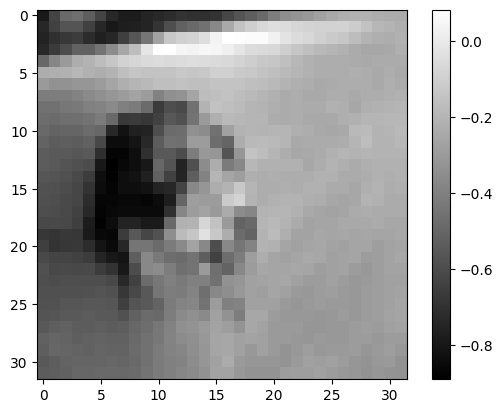

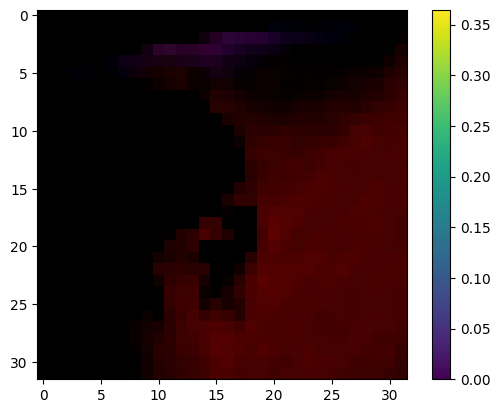

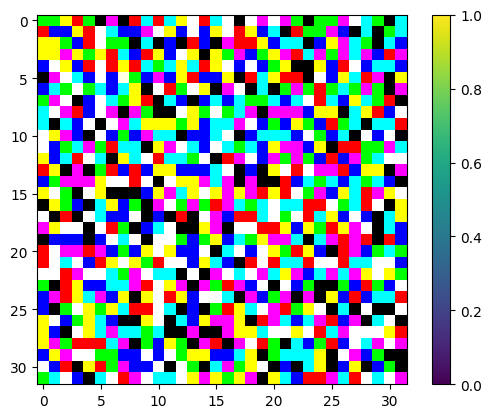

In [ ]:
import matplotlib.pyplot as plt


plt.imshow(a[0,0,:,:].cpu(),cmap='gray')
plt.colorbar()
plt.show()

plt.imshow(c)
plt.colorbar()
plt.show()

plt.imshow(sampled_images.cpu())
plt.colorbar()
plt.show()

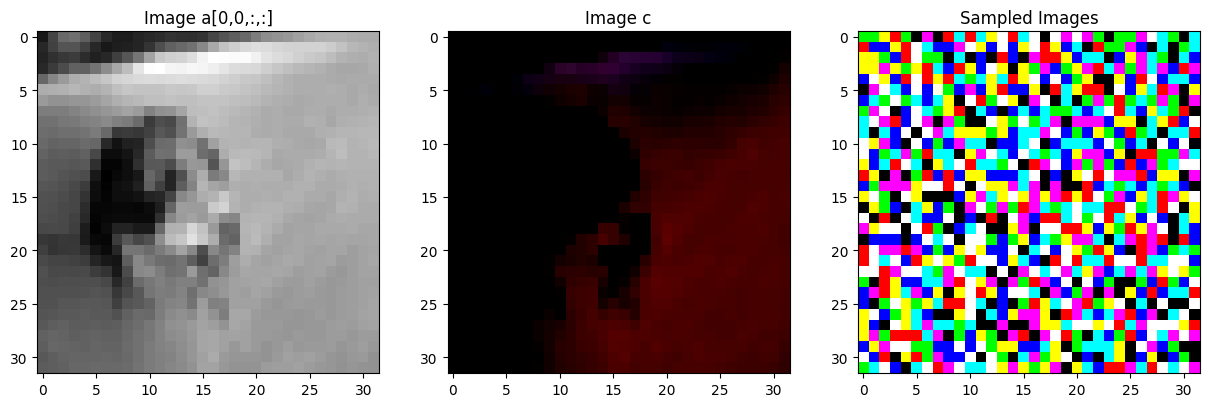

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# First image
axs[0].imshow(a[0,0,:,:].cpu(), cmap='gray')
axs[0].set_title('Image a[0,0,:,:]')


# Second image
axs[1].imshow(c)
axs[1].set_title('Image c')


# Third image
axs[2].imshow(sampled_images.cpu())
axs[2].set_title('Sampled Images')


plt.show()


In [ ]:
torch.min(sampled_images)

tensor(-6256.0386, device='cuda:0')

In [ ]:
x = (sampled_images.cpu() + 1) / 2
x=  x.clamp(-1, 1)
x = (x * 255).type(torch.uint8)

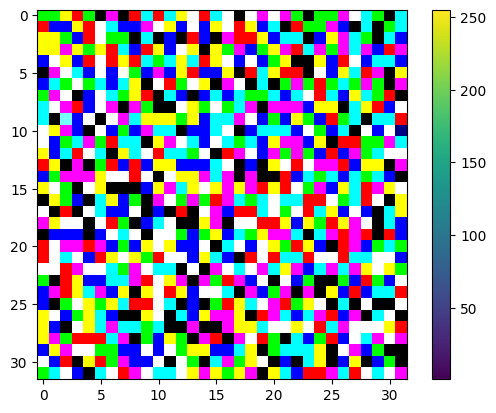

In [ ]:
plt.imshow(x)
plt.colorbar()

In [ ]:
x = (c + 1) / 2
x=  x.clamp(-1, 1)
x = (x * 255).type(torch.uint8)

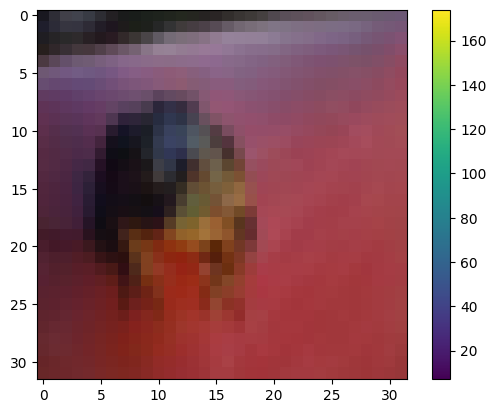

In [ ]:
plt.imshow(x)
plt.colorbar()

In [ ]:
x = (a[0,0,:,:].cpu() + 1) / 2
x=  x.clamp(-1, 1)
x = (x * 255).type(torch.uint8)

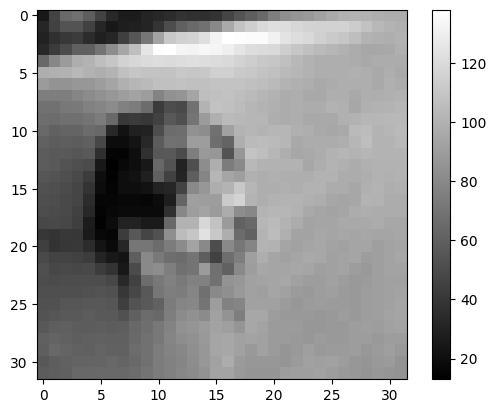

In [ ]:
plt.imshow(x,cmap='gray')
plt.colorbar()

In [ ]:
torch.cuda.empty_cache()


In [ ]:

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from PIL import Image
import numpy as np

from torch.utils.data import DataLoader, Subset

class CIFAR10GrayToColor(Dataset):
    def __init__(self, root, train=True, transform=None):
        self.cifar10 = CIFAR10(root=root, train=train, download=True)
        self.transform = transform

    def __len__(self):
        return len(self.cifar10)

    def __getitem__(self, idx):
        image, _ = self.cifar10[idx]

        # Convert image to grayscale
        gray_image = Image.fromarray(np.array(image)).convert('L')

        if self.transform:
            gray_image = self.transform(gray_image)
            image = self.transform(image)

        return gray_image, image

# Define the transforms



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 36.4 MB/s eta 0:00:0000:0100:01


In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from diffusers import DDPMScheduler, UNet2DModel,CosineDPMSolverMultistepScheduler
from accelerate import Accelerator
from torchvision import datasets
from torch.utils.data import DataLoader, Subset
def training_function():
    # Initialize accelerator
    accelerator = Accelerator()

    # To have only one message (and not 8) per logs of Transformers or Datasets, we set the logging verbosity
#     # to INFO for the main process only.
#     if accelerator.is_main_process:
#         datasets.utils.logging.set_verbosity_warning()
#         transformers.utils.logging.set_verbosity_info()
#     else:
#         datasets.utils.logging.set_verbosity_error()
#         transformers.utils.logging.set_verbosity_error()

    accelerator = Accelerator()

    # Hyperparameters
    image_size = 32  # Ensure image size is a multiple of 8
    batch_size = 64
    learning_rate = 1e-4
    num_epochs = 50

    # Data preparation
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: (x * 2) - 1),  # Scale from [0, 1] to [-1, 1]
    ])

    # Create the dataset
    train_dataset = CIFAR10GrayToColor(root='./data', train=True, transform=transform)
    test_dataset = CIFAR10GrayToColor(root='./data', train=False, transform=transform)

    # Create subsets of 100 images for training
    train_subset = Subset(train_dataset, range(1024))
    test_subset = Subset(test_dataset, range(128))

    # Create the dataloaders
    train_loader = DataLoader(train_subset, batch_size=128, shuffle=True)
    test_loader = DataLoader(test_subset, batch_size=8, shuffle=True)

    # Example usage
    for gray_images, color_images in train_loader:
        print(f"Grayscale batch shape: {gray_images.shape}")
        print(f"Color batch shape: {color_images.shape}")
        break


    # Model setup
    model = UNet2DModel(
        sample_size=image_size,  # Input image size
        in_channels=4,           # Input channels (grayscale for MNIST)
        out_channels=3,          # Output channels
        layers_per_block=4,
        block_out_channels=(64, 128, 256, 512),
    )

    # Scheduler setup
    scheduler = DDPMScheduler(
        num_train_timesteps=4000,  # Number of diffusion steps
        beta_schedule="linear"
    )

    # Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Prepare everything with accelerator
    model, optimizer, train_loader,test_loader  = accelerator.prepare(model, optimizer, train_loader,test_loader)

    # Loss function
    criterion = nn.MSELoss()

    # Instantiate a progress bar to keep track of training. Note that we only enable it on the main
    # process to avoid having 8 progress bars.
    progress_bar = tqdm(range(num_epochs * len(train_loader)), disable=not accelerator.is_main_process)
    # Now we train the model
    for epoch in range(num_epochs):
        model.train()
        losses=[]
        for batch in train_loader:
            gray, color = batch

            # Sample noise to add to the images
            noise = torch.randn_like(color)

            # Sample a random timestep for each image
            timesteps = torch.randint(0, scheduler.config.num_train_timesteps, (gray.shape[0],)).long().to(device=gray.device)


            # Get the noisy images
            noisy_images = scheduler.add_noise(color, noise, timesteps)

            x_t = torch.cat((noisy_images,gray), axis=1)
            # Get the model's prediction
            noise_pred = model(x_t, timesteps).sample

            # Compute the loss
            loss = criterion(noise_pred, noise)

            # Backpropagation and optimization
            optimizer.zero_grad()
            accelerator.backward(loss)
            optimizer.step()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            progress_bar.update(1)
            progress_bar.set_postfix({"loss": loss.item()})

    # Sampling process after training
    model.eval()
    with torch.no_grad():
        num_samples = 8
        # Start from pure noise
        for batch in test_loader:
            gray, color = batch
            break

        samples = torch.randn((num_samples, 3, image_size, image_size)).to(accelerator.device)

        # Iterate over timesteps to denoise
        for t in range(scheduler.config.num_train_timesteps - 1, -1, -1):

            timesteps = torch.full((num_samples,), t, device=accelerator.device, dtype=torch.long)

            # Predict the noise at timestep t
            x_t = torch.cat((samples, gray), axis=1)
            noise_pred = model(x_t, timesteps).sample

            # Get the previous sample using the scheduler
            samples = scheduler.step(noise_pred, t, samples).prev_sample

        # Convert to numpy for visualization
        samples = (samples.clamp(-1, 1) + 1) / 2  # Rescale to [0, 1]
        samples = samples.cpu().numpy()*255.0
        samples= samples.clip(0, 255.0)

        gray = (color + 1) / 2  # Rescale to [0, 1]
        gray = gray.cpu().numpy()*255.0
        gray= gray.clip(0, 255.0)
    #     samples=samples.astype(byte)

    # Display sampled images
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 10))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)

        x =samples[i].transpose(1, 2, 0)
        plt.imshow(x[:,:,:])
#         plt.colorbar()
        plt.axis("off")
    plt.show()

    plt.figure(figsize=(10, 10))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)

#         x =samples[i].transpose(1, 2, 0)
        plt.imshow(x[:,:,0])
#         plt.colorbar()
        plt.axis("off")
    plt.show()

    plt.figure(figsize=(10, 10))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)

#         x =samples[i].transpose(1, 2, 0)
        plt.imshow(x[:,:,1])
#         plt.colorbar()
        plt.axis("off")
    plt.show()

    plt.figure(figsize=(10, 10))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)

        x =samples[i].transpose(1, 2, 0)
        plt.imshow(x[:,:,2])
#         plt.colorbar()
        plt.axis("off")
    plt.show()

    plt.figure(figsize=(10, 10))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        x =gray[i].transpose(1, 2, 0)
        plt.imshow(x)
        plt.axis("off")

    plt.show()
    return model, test_loader

Launching training on one GPU.
Files already downloaded and verified
Files already downloaded and verified
Grayscale batch shape: torch.Size([128, 1, 32, 32])
Color batch shape: torch.Size([128, 3, 32, 32])


  0%|          | 0/400 [00:00<?, ?it/s]

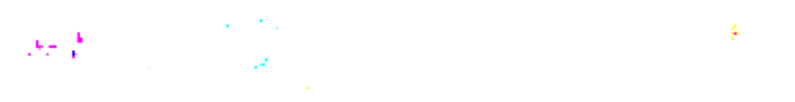

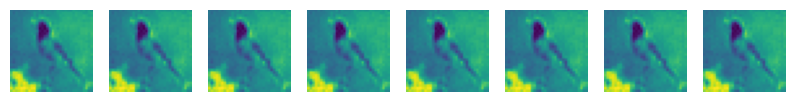

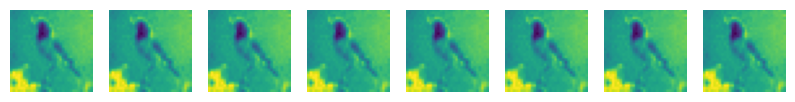

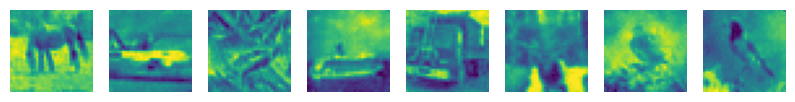

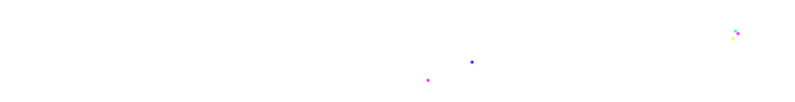

In [ ]:
from tqdm.auto import tqdm
import numpy as np

from accelerate import notebook_launcher

notebook_launcher(training_function,num_processes=1)

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from diffusers import DDPMScheduler, UNet2DModel,CosineDPMSolverMultistepScheduler
from accelerate import Accelerator
from torchvision import datasets
from torch.utils.data import DataLoader, Subset

2024-08-25 17:27:51.818094: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-25 17:27:51.818241: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-25 17:27:51.961231: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x * 2) - 1),  # Scale from [0, 1] to [-1, 1]
])

# Create the dataset
train_dataset = CIFAR10GrayToColor(root='./data', train=True, transform=transform)
test_dataset = CIFAR10GrayToColor(root='./data', train=False, transform=transform)

# Create subsets of 100 images for training
train_subset = Subset(train_dataset, range(1024))
test_subset = Subset(test_dataset, range(128))

# Create the dataloaders
train_loader = DataLoader(train_subset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=8, shuffle=True)

100%|██████████| 170498071/170498071 [00:10<00:00, 16151649.11it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
reverse_transform = transforms.Compose([
    transforms.Lambda(lambda x: x.clamp(-1, 1)),            # Step 1: Clip values to the range [-1, 1]
    transforms.Lambda(lambda x: (x + 1) / 2),               # Step 2: Transform to range [0, 1]
    transforms.Lambda(lambda x: x * 255),                   # Step 3: Scale to range [0, 255]
    transforms.Lambda(lambda x: x.permute(1, 2, 0)),        # Step 4: Permute to shape H x W x C
    transforms.Lambda(lambda x: x.byte()),                  # Convert to byte (uint8)
])

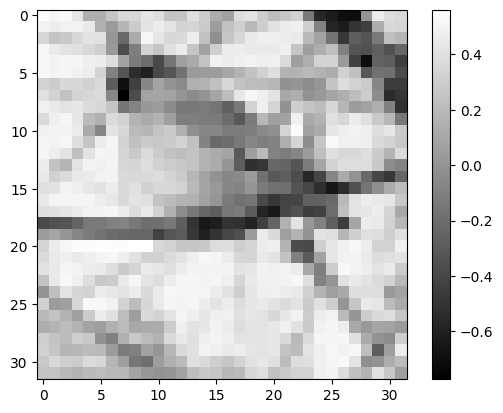

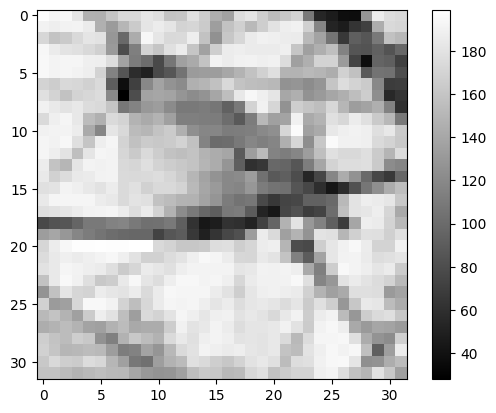

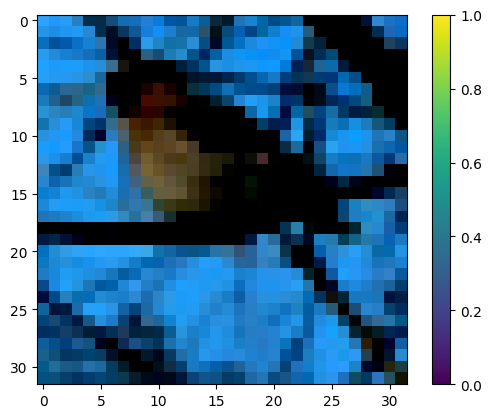

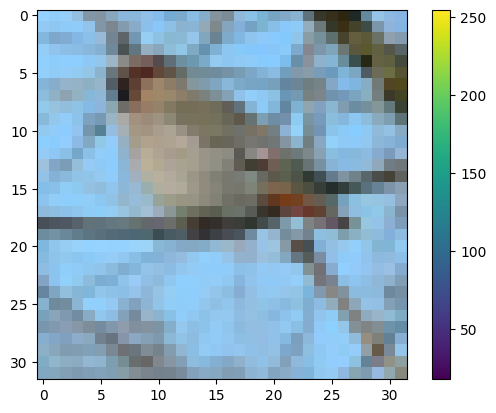

In [ ]:
import matplotlib.pyplot as plt
for gray, color in train_loader:
    grey = gray[0]
    col = color[0]

    plt.imshow(grey[0],cmap='gray')
    plt.colorbar()
    plt.show()

    plt.imshow(reverse_transform(grey),cmap='gray')
    plt.colorbar()
    plt.show()

    plt.imshow(col.permute(1,2,0))
    plt.colorbar()
    plt.show()

    plt.imshow(reverse_transform(col))
    plt.colorbar()
    plt.show()

    break




In [ ]:
!pip install torch torchvision diffusers accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 35.4 MB/s eta 0:00:0000:0100:01


In [ ]:

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from PIL import Image
import numpy as np

from torch.utils.data import DataLoader, Subset

class CIFAR10GrayToColor(Dataset):
    def __init__(self, root, train=True, transform=None):
        self.cifar10 = CIFAR10(root=root, train=train, download=True)
        self.transform = transform

    def __len__(self):
        return len(self.cifar10)

    def __getitem__(self, idx):
        image, _ = self.cifar10[idx]

        # Convert image to grayscale
        gray_image = Image.fromarray(np.array(image)).convert('L')

        if self.transform:
            gray_image = self.transform(gray_image)
            image = self.transform(image)

        return gray_image, image

In [ ]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: (x * 2) - 1),  # Scale from [0, 1] to [-1, 1]
    ])

reverse_transform = transforms.Compose([
    transforms.Lambda(lambda x: x.clamp(-1, 1)),            # Step 1: Clip values to the range [-1, 1]
    transforms.Lambda(lambda x: (x + 1) / 2),               # Step 2: Transform to range [0, 1]
    transforms.Lambda(lambda x: x * 255),                   # Step 3: Scale to range [0, 255]
    transforms.Lambda(lambda x: x.permute(1, 2, 0)),        # Step 4: Permute to shape H x W x C
    transforms.Lambda(lambda x: x.byte()),                  # Convert to byte (uint8)
])

# Create the dataset
train_dataset = CIFAR10GrayToColor(root='./data', train=True, transform=transform)
test_dataset = CIFAR10GrayToColor(root='./data', train=False, transform=transform)

# Create subsets of 100 images for training
train_subset = Subset(train_dataset, range(9999))
test_subset = Subset(test_dataset, range(128))

# Create the dataloaders
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=8, shuffle=True)


100%|██████████| 170498071/170498071 [00:04<00:00, 35182282.64it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
len(train_loader)

157

In [ ]:
image_size = 32  # Ensure image size is a multiple of 8
# batch_size = 16
learning_rate = 1e-4
num_epochs = 100

In [ ]:
import numpy as np
import tqdm

In [ ]:
import torch
import torch.nn as nn
from tqdm import tqdm
from torch.optim import Adam
# from some_module import UNet2DModel, DDPMScheduler  # Replace with actual import paths
from diffusers import DDPMScheduler, UNet2DModel,CosineDPMSolverMultistepScheduler
# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Model setup
model = UNet2DModel(
    sample_size=image_size,  # Input image size
    in_channels=4,           # Input channels (3 for RGB + 1 for grayscale)
    out_channels=3,          # Output channels (RGB)
    layers_per_block=4,
    block_out_channels=(64, 128, 256, 512),
).to(device)

# Scheduler setup
scheduler = DDPMScheduler(
    num_train_timesteps=1000,  # Number of diffusion steps
    beta_schedule="linear"
)

# Optimizer
optimizer = Adam(model.parameters(), lr=learning_rate)

# Loss function
criterion = nn.MSELoss()

# Training loop
for epoch in range(num_epochs):
    model.train()
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for batch in progress_bar:
        # Assuming train_loader provides a tuple (grayscale_image, color_image)
        gray, color = batch
        gray, color = gray.to(device), color.to(device)

        # Sample noise to add to the images
        noise = torch.randn_like(color)

        # Sample a random timestep for each image
        timesteps = torch.randint(0, scheduler.config.num_train_timesteps, (gray.shape[0],)).long().to(device)

        # Get the noisy images
        noisy_images = scheduler.add_noise(color, noise, timesteps)

        # Concatenate the grayscale and noisy color images
        x_t = torch.cat((noisy_images, gray), dim=1)

        # Get the model's prediction
        noise_pred = model(x_t, timesteps).sample

        # Compute the loss
        loss = criterion(noise_pred, noise)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Update progress bar
        progress_bar.set_postfix({"loss": loss.item()})


2024-08-25 18:38:50.181772: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-25 18:38:50.181914: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-25 18:38:50.320884: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Epoch 100/100: 100%|██████████| 157/157 [01:16<00:00,  2.06it/s, loss=0.00126]


In [ ]:
import torch
from tqdm import tqdm

model.eval()
with torch.no_grad():
    num_samples = 8

    # Get a batch from the test_loader
    for batch in test_loader:
        gray, color = batch
        gray, color = gray.to(device), color.to(device)
        break

    # Start from pure noise
    samples = torch.randn((num_samples, 3, image_size, image_size)).to(device)

    # Initialize the progress bar for the timesteps
    progress_bar = tqdm(total=scheduler.config.num_train_timesteps, desc="Denoising Timesteps", leave=True)

    # Iterate over timesteps to denoise
    for t in range(scheduler.config.num_train_timesteps - 1, -1, -1):
        timesteps = torch.full((num_samples,), t, device=device, dtype=torch.long)

        # Predict the noise at timestep t
        x_t = torch.cat((samples, gray), axis=1)
        noise_pred = model(x_t, timesteps).sample

        # Get the previous sample using the scheduler
        samples = scheduler.step(noise_pred, t, samples).prev_sample

        # Update the progress bar
        progress_bar.update(1)

    # Close the progress bar after completion
    progress_bar.close()

# The 'samples' can now be used for visualization or saving


Denoising Timesteps: 100%|██████████| 1000/1000 [00:43<00:00, 22.86it/s]


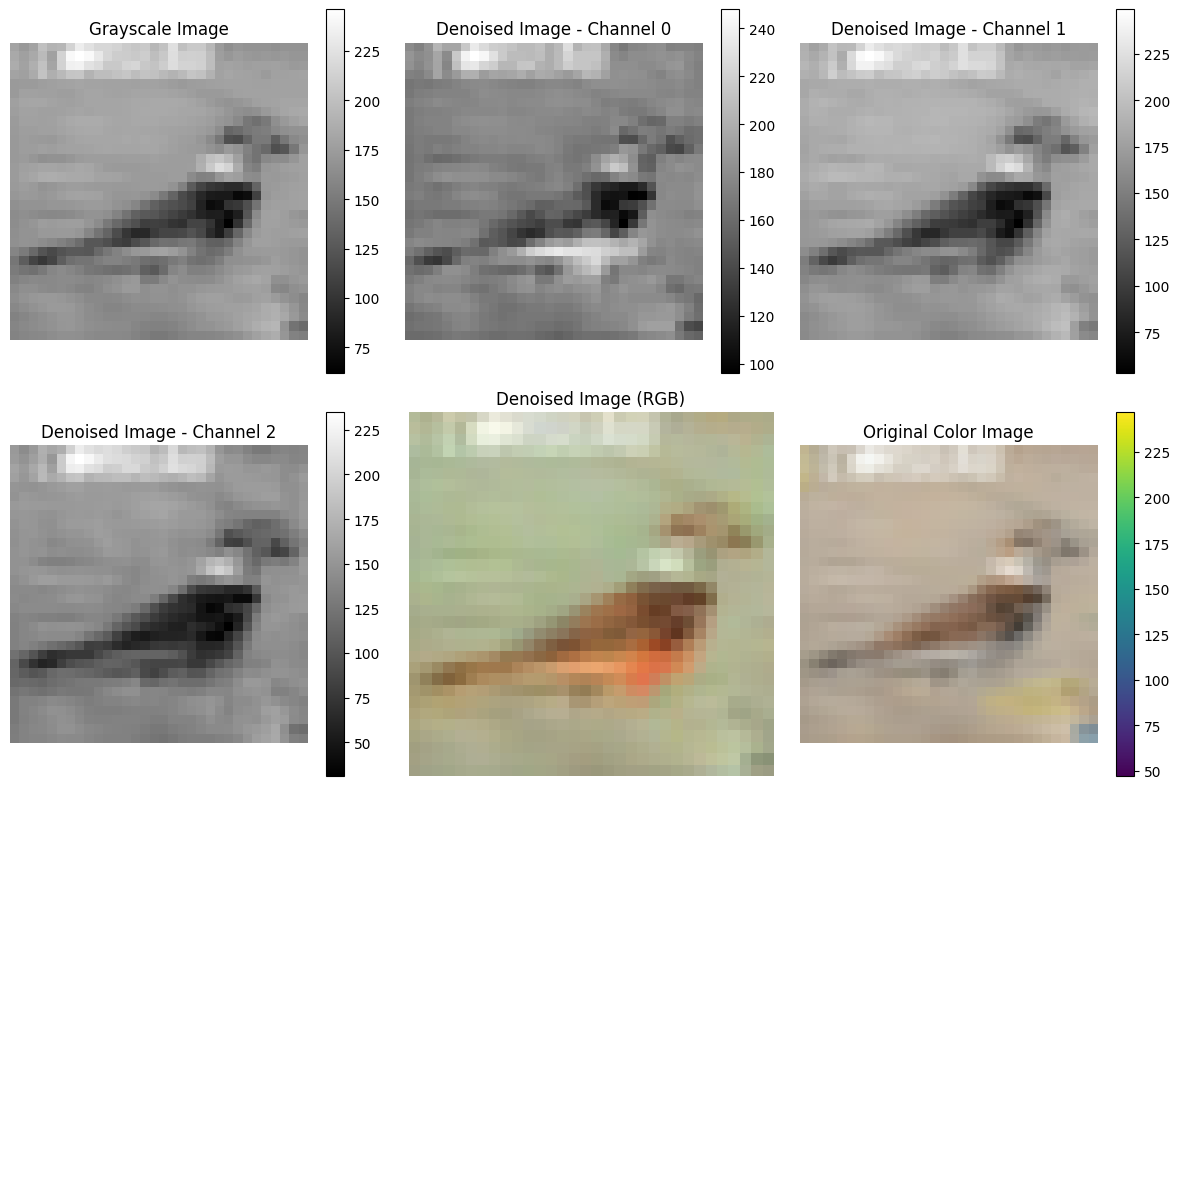

In [ ]:
import matplotlib.pyplot as plt

# Create a figure with subplots
fig, axs = plt.subplots(3, 3, figsize=(12, 12))

# Display the grayscale image
sample_gray = reverse_transform(gray[-3]).cpu()
axs[0, 0].imshow(sample_gray, cmap='gray')
axs[0, 0].set_title('Grayscale Image')
axs[0, 0].axis('off')

# Display the color channels of the denoised sample
sample_denoised = reverse_transform(samples[-3]).cpu()

axs[0, 1].imshow(sample_denoised[:, :, 0], cmap='gray')
axs[0, 1].set_title('Denoised Image - Channel 0')
axs[0, 1].axis('off')

axs[0, 2].imshow(sample_denoised[:, :, 1], cmap='gray')
axs[0, 2].set_title('Denoised Image - Channel 1')
axs[0, 2].axis('off')

axs[1, 0].imshow(sample_denoised[:, :, 2], cmap='gray')
axs[1, 0].set_title('Denoised Image - Channel 2')
axs[1, 0].axis('off')

# Display the full denoised image
axs[1, 1].imshow(sample_denoised)
axs[1, 1].set_title('Denoised Image (RGB)')
axs[1, 1].axis('off')

# Display the original color image
sample_color = reverse_transform(color[-3]).cpu()
axs[1, 2].imshow(sample_color)
axs[1, 2].set_title('Original Color Image')
axs[1, 2].axis('off')

# Add colorbars
for i in range(2):
    for j in range(3):
        if i == 0 or (i == 1 and j in [0, 2]):
            fig.colorbar(axs[i, j].images[0], ax=axs[i, j])

# Hide unused subplots
axs[2, 0].axis('off')
axs[2, 1].axis('off')
axs[2, 2].axis('off')

plt.tight_layout()
plt.show()


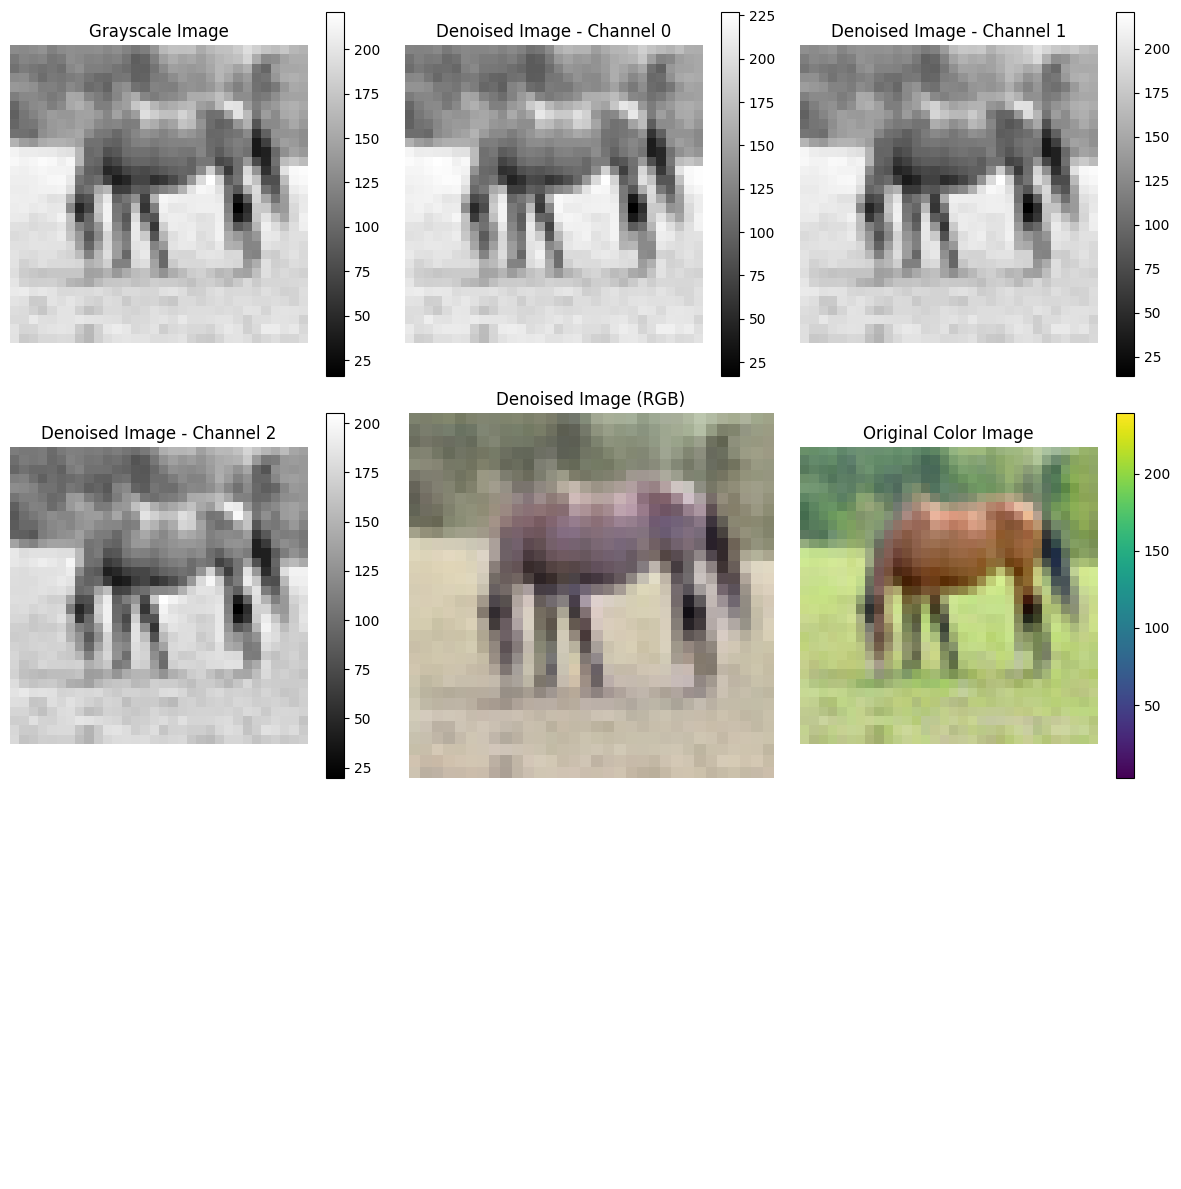

In [ ]:
import matplotlib.pyplot as plt

# Create a figure with subplots
fig, axs = plt.subplots(3, 3, figsize=(12, 12))

# Display and save the grayscale image
sample_gray = reverse_transform(gray[-3]).cpu().squeeze()  # Ensure it's 2D
axs[0, 0].imshow(sample_gray, cmap='gray')
axs[0, 0].set_title('Grayscale Image')
axs[0, 0].axis('off')
plt.imsave('grayscale_image.png', sample_gray.numpy(), cmap='gray')

# Display and save the color channels of the denoised sample
sample_denoised = reverse_transform(samples[-3]).cpu()

axs[0, 1].imshow(sample_denoised[:, :, 0], cmap='gray')
axs[0, 1].set_title('Denoised Image - Channel 0')
axs[0, 1].axis('off')
plt.imsave('denoised_channel_0.png', sample_denoised[:, :, 0].numpy(), cmap='gray')

axs[0, 2].imshow(sample_denoised[:, :, 1], cmap='gray')
axs[0, 2].set_title('Denoised Image - Channel 1')
axs[0, 2].axis('off')
plt.imsave('denoised_channel_1.png', sample_denoised[:, :, 1].numpy(), cmap='gray')

axs[1, 0].imshow(sample_denoised[:, :, 2], cmap='gray')
axs[1, 0].set_title('Denoised Image - Channel 2')
axs[1, 0].axis('off')
plt.imsave('denoised_channel_2.png', sample_denoised[:, :, 2].numpy(), cmap='gray')

# Display and save the full denoised image
axs[1, 1].imshow(sample_denoised)
axs[1, 1].set_title('Denoised Image (RGB)')
axs[1, 1].axis('off')
plt.imsave('denoised_image_rgb.png', sample_denoised.numpy())

# Display and save the original color image
sample_color = reverse_transform(color[2]).cpu()
axs[1, 2].imshow(sample_color)
axs[1, 2].set_title('Original Color Image')
axs[1, 2].axis('off')
plt.imsave('original_color_image.png', sample_color.numpy())

# Add colorbars
for i in range(2):
    for j in range(3):
        if i == 0 or (i == 1 and j in [0, 2]):
            fig.colorbar(axs[i, j].images[0], ax=axs[i, j])

# Hide unused subplots
axs[2, 0].axis('off')
axs[2, 1].axis('off')
axs[2, 2].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# Specify the path where you want to save the model
save_path = "model_weights.pth"

# Save the model's state dictionary
torch.save(model.state_dict(), save_path)

In [ ]:
# import torch
# from some_module import UNet2DModel  # Replace with the actual import path

# Define the model architecture
new_model = UNet2DModel(
    sample_size=image_size,  # Input image size
    in_channels=4,           # Input channels (grayscale + RGB)
    out_channels=3,          # Output channels (RGB)
    layers_per_block=4,
    block_out_channels=(64, 128, 256, 512),
).to(device)


In [ ]:
# Load the saved model weights
new_model.load_state_dict(torch.load("model_weights.pth"))


<All keys matched successfully>

In [ ]:
import torch
from tqdm import tqdm


new_model.eval()
with torch.no_grad():
    num_samples = 8

    # Get a batch from the test_loader
    for batch in test_loader:
        gray, color = batch
        gray, color = gray.to(device), color.to(device)
        break

    # Start from pure noise
    samples = torch.randn((num_samples, 3, image_size, image_size)).to(device)

    # Initialize the progress bar for the timesteps
    progress_bar = tqdm(total=scheduler.config.num_train_timesteps, desc="Denoising Timesteps", leave=True)

    # Iterate over timesteps to denoise
    for t in range(scheduler.config.num_train_timesteps - 1, -1, -1):
        timesteps = torch.full((num_samples,), t, device=device, dtype=torch.long)

        # Predict the noise at timestep t
        x_t = torch.cat((samples, gray), axis=1)
        noise_pred = new_model(x_t, timesteps).sample

        # Get the previous sample using the scheduler
        samples = scheduler.step(noise_pred, t, samples).prev_sample

        # Update the progress bar
        progress_bar.update(1)

    # Close the progress bar after completion
    progress_bar.close()

# The 'samples' can now be used for visualization or saving



Denoising Timesteps: 100%|██████████| 1000/1000 [00:43<00:00, 23.09it/s][A


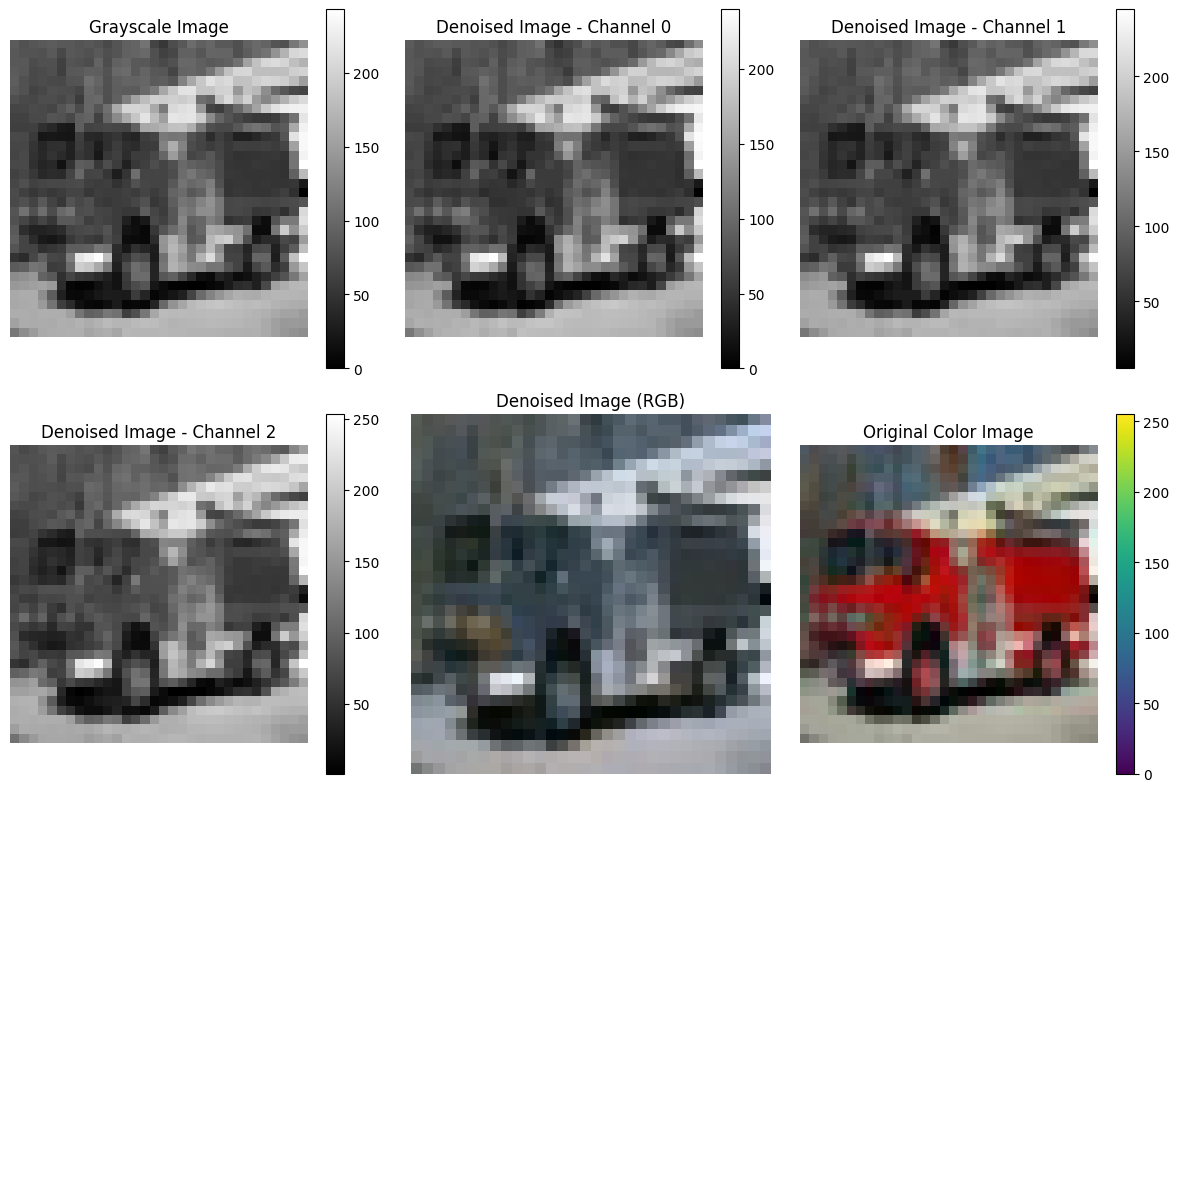

In [ ]:
import matplotlib.pyplot as plt

# Create a figure with subplots
fig, axs = plt.subplots(3, 3, figsize=(12, 12))

# Display the grayscale image
sample_gray = reverse_transform(gray[5]).cpu()
axs[0, 0].imshow(sample_gray, cmap='gray')
axs[0, 0].set_title('Grayscale Image')
axs[0, 0].axis('off')

# Display the color channels of the denoised sample
sample_denoised = reverse_transform(samples[5]).cpu()

axs[0, 1].imshow(sample_denoised[:, :, 0], cmap='gray')
axs[0, 1].set_title('Denoised Image - Channel 0')
axs[0, 1].axis('off')

axs[0, 2].imshow(sample_denoised[:, :, 1], cmap='gray')
axs[0, 2].set_title('Denoised Image - Channel 1')
axs[0, 2].axis('off')

axs[1, 0].imshow(sample_denoised[:, :, 2], cmap='gray')
axs[1, 0].set_title('Denoised Image - Channel 2')
axs[1, 0].axis('off')

# Display the full denoised image
axs[1, 1].imshow(sample_denoised)
axs[1, 1].set_title('Denoised Image (RGB)')
axs[1, 1].axis('off')

# Display the original color image
sample_color = reverse_transform(color[5]).cpu()
axs[1, 2].imshow(sample_color)
axs[1, 2].set_title('Original Color Image')
axs[1, 2].axis('off')

# Add colorbars
for i in range(2):
    for j in range(3):
        if i == 0 or (i == 1 and j in [0, 2]):
            fig.colorbar(axs[i, j].images[0], ax=axs[i, j])

# Hide unused subplots
axs[2, 0].axis('off')
axs[2, 1].axis('off')
axs[2, 2].axis('off')

plt.tight_layout()
plt.show()
